In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import os
from google.colab import drive
import copy
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from google.colab import data_table
from google.colab import drive
from torch.utils.data import random_split, DataLoader, Dataset
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn.functional as F
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import torchvision.transforms.functional as TF
import torchvision.transforms as T


drive.mount('/content/drive')

!ls "/content/drive/MyDrive/BreastCancerProject/Datasets"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 mammograms_2  'Potential Breast Cancer Datasets.docx'


In [2]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np

dir = '/content/drive/MyDrive/BreastCancerProject/Datasets'
dataset_dir = os.path.join(dir, 'mammograms_2')

class PairedImageDataset(Dataset):
    def __init__(self, root, transform=None, mask_transform=None):
        self.root = root
        self.transform = transform
        self.mask_transform = mask_transform
        self.data = []
        self.label_map = {'benign': 0, 'malignant': 1, 'normal': 2}
        valid_exts = ['.jpg', '.png', '.jpeg']

        for label_name in os.listdir(root):
            class_dir = os.path.join(root, label_name)
            if not os.path.isdir(class_dir):
                continue

            original_label = self.label_map.get(label_name)
            if original_label is None:
                continue

            for fname in os.listdir(class_dir):
                ext = os.path.splitext(fname)[1].lower()
                if ext not in valid_exts or '_mask' in fname:
                    continue

                base_name = os.path.splitext(fname)[0]
                original_path = os.path.join(class_dir, fname)

                for mask_ext in valid_exts:
                    mask_path = os.path.join(class_dir, f"{base_name}_mask{mask_ext}")
                    if os.path.exists(mask_path):
                        mask_img = np.array(Image.open(mask_path).convert("L"))
                        is_empty_mask = np.all(mask_img == 0)

                        if original_label == 2:
                            if is_empty_mask:
                                self.data.append((original_path, mask_path, original_label))
                            break
                        else:
                            new_label = 2 if is_empty_mask else original_label
                            self.data.append((original_path, mask_path, new_label))
                            break

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        orig_path, mask_path, label = self.data[idx]
        orig_img = Image.open(orig_path).convert("L")
        mask_img = Image.open(mask_path).convert("L")

        if self.transform:
            orig_img = self.transform(orig_img)
        if self.mask_transform:
            mask_img = self.mask_transform(mask_img)

        return orig_img, mask_img, label

image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

dataset = PairedImageDataset(
    root=dataset_dir,
    transform=image_transform,
    mask_transform=mask_transform
)

orig, mask, label = dataset[0]
print(orig.shape, mask.shape, label)

def labeler(label):
    if label == 0:
        return "Benign"
    elif label == 1:
        return "Malignant"
    elif label == 2:
        return "Normal"

torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) 2


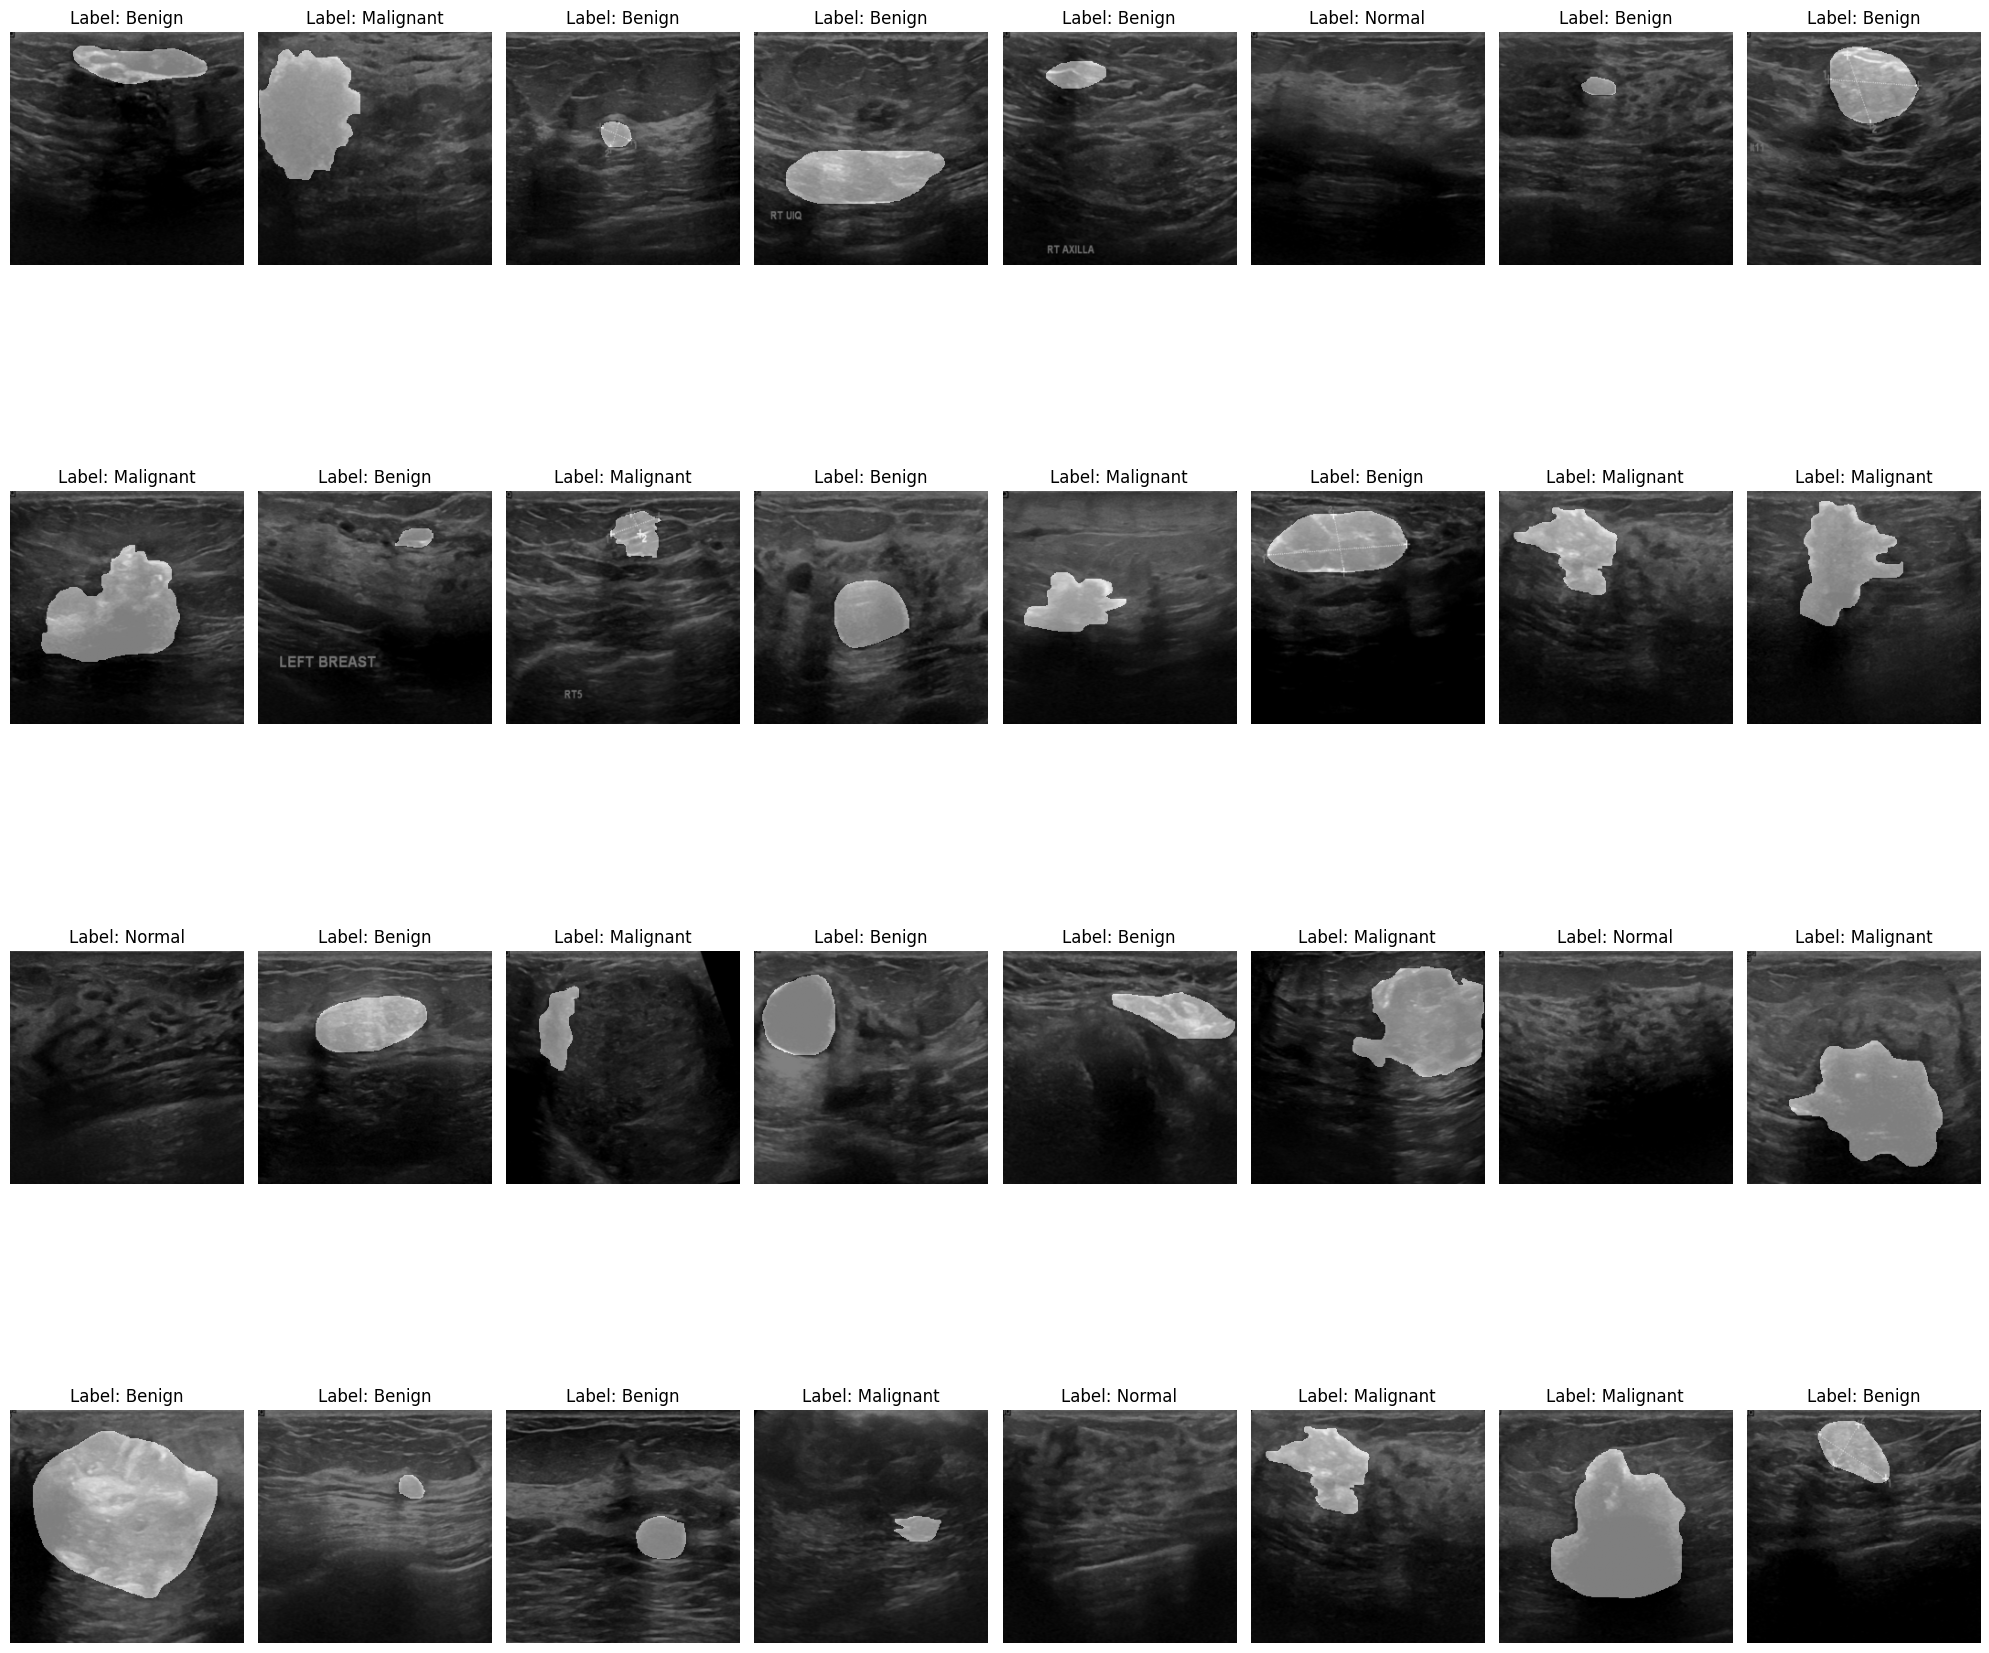

In [13]:

def plot_random_images_from_dataset(dataset, labeler, num_images=32):
    num_images = min(num_images, len(dataset))
    random_indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(20, 20))
    for i, index in enumerate(random_indices):
        original_image, mask_image, label = dataset[index]

        plt.subplot(4, 8, i + 1)
        plt.imshow(original_image.permute(1, 2, 0), cmap='gray')
        plt.imshow(mask_image.squeeze(), cmap='gray', alpha=0.5)

        plt.title(f"Label: {labeler(label)}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_random_images_from_dataset(dataset, labeler)

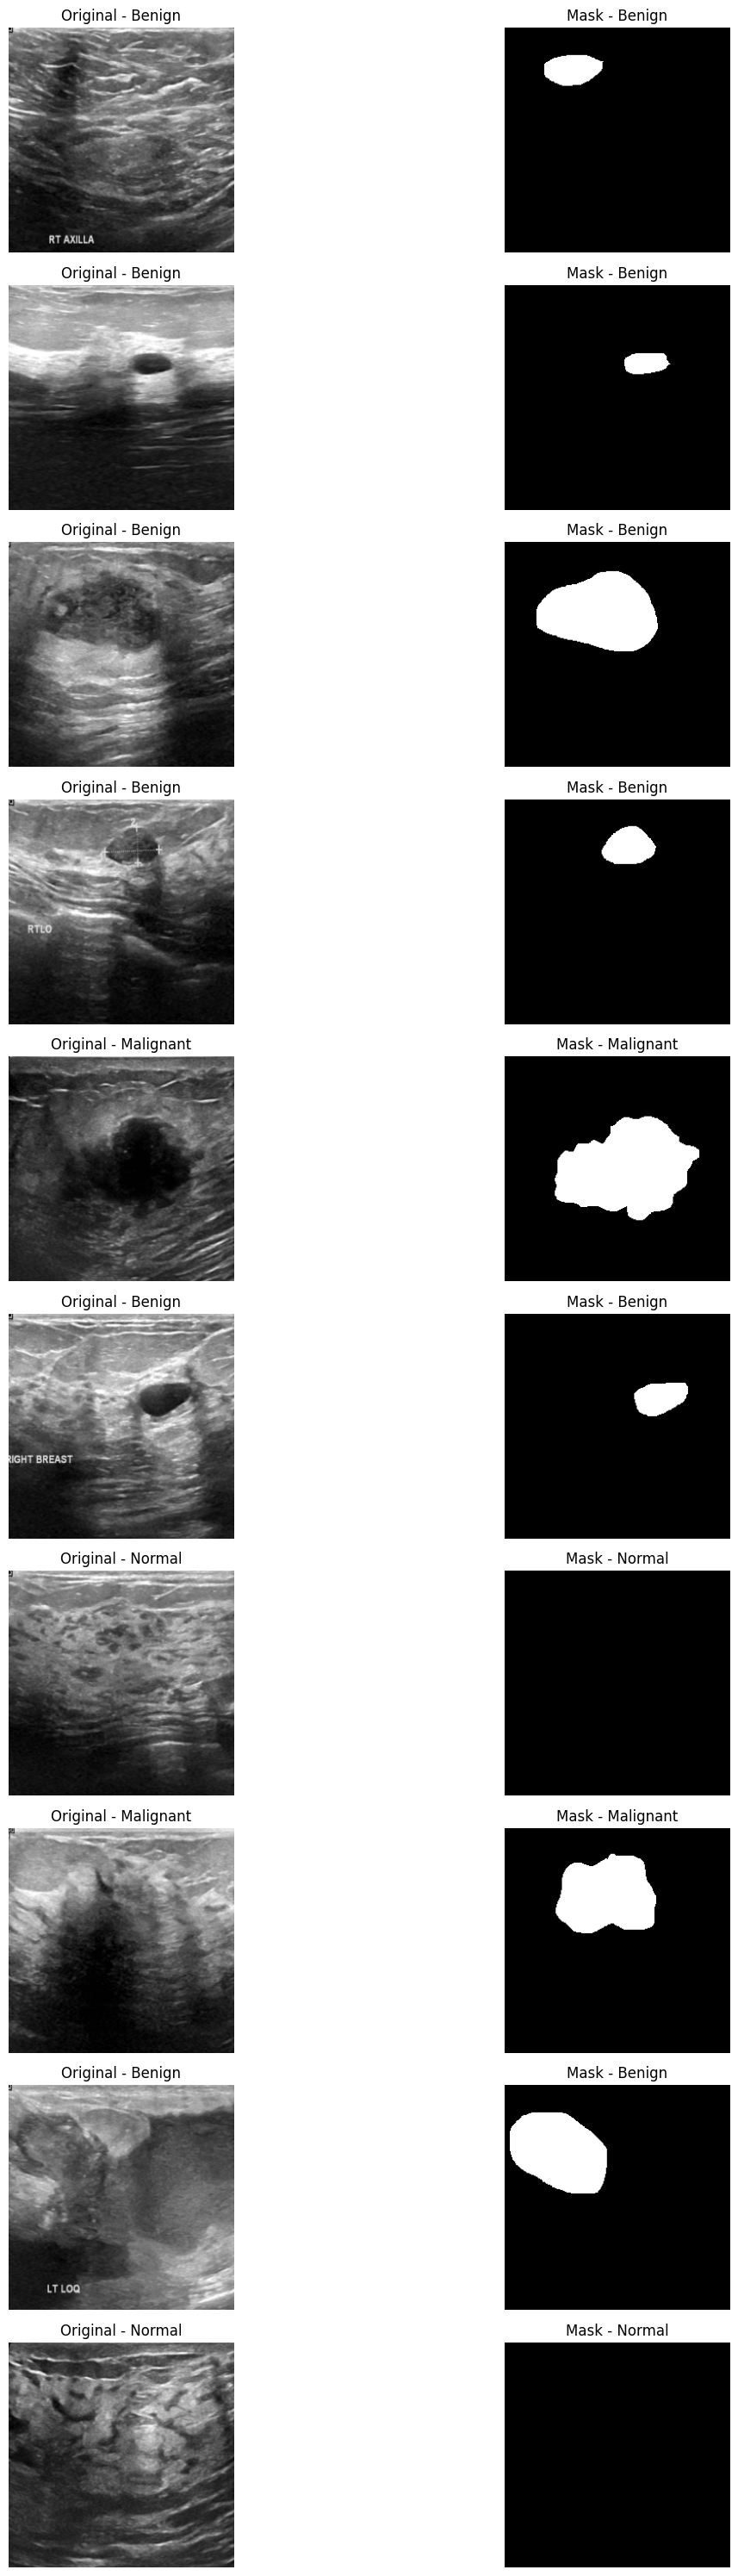

In [ ]:
def plot_random_images_from_dataset(dataset, labeler, num_images=10):
    num_images = min(num_images, len(dataset))
    random_indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(15, num_images * 3))  # Taller figure for side-by-side plots

    for i, index in enumerate(random_indices):
        original_image, mask_image, label = dataset[index]

        # Plot original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(original_image.permute(1, 2, 0), cmap='gray')
        plt.title(f"Original - {labeler(label)}")
        plt.axis('off')

        # Plot mask image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(mask_image.squeeze(), cmap='gray')
        plt.title(f"Mask - {labeler(label)}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
plot_random_images_from_dataset(dataset, labeler)

In [ ]:
from collections import Counter

label_counts = Counter()
for _, _, label in dataset:
    label_counts[labeler(label)] += 1

total_images = len(dataset)

print("Class Distribution:")
for label_name, count in label_counts.items():
    print(f"{label_name}: {count}")

print(f"\nTotal Images: {total_images}")


Class Distribution:
Normal: 266
Benign: 874
Malignant: 420

Total Images: 1560


In [3]:

image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

class CustomDataset(Dataset):
    def __init__(self, original_image_paths, masked_image_paths, labels,
                 image_transform=None, mask_transform=None):
        self.original_image_paths = original_image_paths
        self.masked_image_paths = masked_image_paths
        self.labels = labels
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.original_image_paths)

    def __getitem__(self, index):
        original_image = Image.open(self.original_image_paths[index]).convert("L")
        masked_image = Image.open(self.masked_image_paths[index]).convert("L")
        label = self.labels[index]

        if self.image_transform:
            original_image = self.image_transform(original_image)
        if self.mask_transform:
            masked_image = self.mask_transform(masked_image)

        return original_image, masked_image, label

all_orig_paths = [x[0] for x in dataset.data]
all_mask_paths = [x[1] for x in dataset.data]
all_labels = [x[2] for x in dataset.data]

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_val_idx, test_idx in sss1.split(all_orig_paths, all_labels):
    train_val_orig = [all_orig_paths[i] for i in train_val_idx]
    train_val_mask = [all_mask_paths[i] for i in train_val_idx]
    train_val_labels = [all_labels[i] for i in train_val_idx]

    test_orig = [all_orig_paths[i] for i in test_idx]
    test_mask = [all_mask_paths[i] for i in test_idx]
    test_labels = [all_labels[i] for i in test_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_idx, val_idx in sss2.split(train_val_orig, train_val_labels):
    train_orig = [train_val_orig[i] for i in train_idx]
    train_mask = [train_val_mask[i] for i in train_idx]
    train_labels = [train_val_labels[i] for i in train_idx]

    val_orig = [train_val_orig[i] for i in val_idx]
    val_mask = [train_val_mask[i] for i in val_idx]
    val_labels = [train_val_labels[i] for i in val_idx]

train_dataset = CustomDataset(train_orig, train_mask, train_labels,
                              image_transform=image_transform,
                              mask_transform=mask_transform)
val_dataset = CustomDataset(val_orig, val_mask, val_labels,
                            image_transform=image_transform,
                            mask_transform=mask_transform)
test_dataset = CustomDataset(test_orig, test_mask, test_labels,
                             image_transform=image_transform,
                             mask_transform=mask_transform)

class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


Train E1: 100%|█████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.36it/s]


Epoch 1: Train [C L 1.0537 | S L 2.4560 | Acc 45.4% | IoU 0.069]   Val   [C L 1.1515 | S L 0.6396 | Acc 27.1% | IoU 0.000]


Train E2: 100%|█████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 2: Train [C L 1.0112 | S L 2.3687 | Acc 51.2% | IoU 0.138]   Val   [C L 1.0143 | S L 0.6156 | Acc 53.2% | IoU 0.181]


Train E3: 100%|█████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.27it/s]


Epoch 3: Train [C L 0.8886 | S L 2.3292 | Acc 61.2% | IoU 0.172]   Val   [C L 0.8125 | S L 0.6845 | Acc 63.3% | IoU 0.134]


Train E4: 100%|█████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 4: Train [C L 0.7943 | S L 2.2589 | Acc 67.0% | IoU 0.200]   Val   [C L 0.7594 | S L 0.5713 | Acc 67.6% | IoU 0.240]


Train E5: 100%|█████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.33it/s]


Epoch 5: Train [C L 0.7090 | S L 2.2262 | Acc 71.6% | IoU 0.203]   Val   [C L 0.6572 | S L 0.5795 | Acc 72.9% | IoU 0.219]


Train E6: 100%|█████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 6: Train [C L 0.6869 | S L 2.1972 | Acc 73.0% | IoU 0.207]   Val   [C L 0.6528 | S L 0.5750 | Acc 75.0% | IoU 0.217]


Train E7: 100%|█████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 7: Train [C L 0.6093 | S L 2.1664 | Acc 77.2% | IoU 0.203]   Val   [C L 1.2086 | S L 0.5221 | Acc 51.6% | IoU 0.286]


Train E8: 100%|█████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 8: Train [C L 0.7046 | S L 2.1267 | Acc 72.3% | IoU 0.214]   Val   [C L 0.8141 | S L 0.5596 | Acc 64.9% | IoU 0.206]


Train E9: 100%|█████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 9: Train [C L 0.5580 | S L 2.0674 | Acc 77.8% | IoU 0.237]   Val   [C L 0.9738 | S L 0.5569 | Acc 62.8% | IoU 0.227]


Train E10: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.36it/s]


Epoch 10: Train [C L 0.6008 | S L 2.0232 | Acc 76.8% | IoU 0.244]   Val   [C L 0.5528 | S L 0.4937 | Acc 81.4% | IoU 0.304]


Train E11: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 11: Train [C L 0.5247 | S L 1.9845 | Acc 80.4% | IoU 0.271]   Val   [C L 0.6245 | S L 0.4788 | Acc 73.9% | IoU 0.344]


Train E12: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.40it/s]


Epoch 12: Train [C L 0.4879 | S L 1.9644 | Acc 82.7% | IoU 0.267]   Val   [C L 0.5944 | S L 0.4798 | Acc 73.4% | IoU 0.348]


Train E13: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.33it/s]


Epoch 13: Train [C L 0.4224 | S L 1.9294 | Acc 85.0% | IoU 0.294]   Val   [C L 1.0375 | S L 0.4699 | Acc 58.5% | IoU 0.352]


Train E14: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.29it/s]


Epoch 14: Train [C L 0.4179 | S L 1.9209 | Acc 85.8% | IoU 0.292]   Val   [C L 0.4389 | S L 0.4556 | Acc 83.0% | IoU 0.393]


Train E15: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.37it/s]


Epoch 15: Train [C L 0.3694 | S L 1.9175 | Acc 87.9% | IoU 0.291]   Val   [C L 0.6698 | S L 0.4605 | Acc 70.7% | IoU 0.404]


Train E16: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.39it/s]


Epoch 16: Train [C L 0.3440 | S L 1.8995 | Acc 89.8% | IoU 0.298]   Val   [C L 0.4637 | S L 0.4358 | Acc 83.0% | IoU 0.399]


Train E17: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.40it/s]


Epoch 17: Train [C L 0.3529 | S L 1.8896 | Acc 89.9% | IoU 0.310]   Val   [C L 0.5678 | S L 0.4630 | Acc 75.5% | IoU 0.363]


Train E18: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 18: Train [C L 0.3598 | S L 1.8906 | Acc 90.3% | IoU 0.307]   Val   [C L 0.7554 | S L 0.4567 | Acc 68.6% | IoU 0.389]


Train E19: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 19: Train [C L 0.2990 | S L 1.8775 | Acc 91.5% | IoU 0.306]   Val   [C L 0.3453 | S L 0.4441 | Acc 88.3% | IoU 0.396]


Train E20: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.39it/s]


Epoch 20: Train [C L 0.3170 | S L 1.8379 | Acc 90.4% | IoU 0.332]   Val   [C L 0.4088 | S L 0.4385 | Acc 84.0% | IoU 0.427]


Train E21: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.36it/s]


Epoch 21: Train [C L 0.2927 | S L 1.8455 | Acc 91.8% | IoU 0.331]   Val   [C L 0.3384 | S L 0.4344 | Acc 88.8% | IoU 0.417]


Train E22: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.33it/s]


Epoch 22: Train [C L 0.2973 | S L 1.8509 | Acc 92.5% | IoU 0.321]   Val   [C L 1.0999 | S L 0.4418 | Acc 57.4% | IoU 0.408]


Train E23: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 23: Train [C L 0.2808 | S L 1.8373 | Acc 92.4% | IoU 0.325]   Val   [C L 0.4682 | S L 0.4348 | Acc 79.8% | IoU 0.423]


Train E24: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.65it/s]


Epoch 24: Train [C L 0.2846 | S L 1.8340 | Acc 92.5% | IoU 0.333]   Val   [C L 0.3482 | S L 0.4430 | Acc 87.2% | IoU 0.425]


Train E25: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.60it/s]


Epoch 25: Train [C L 0.2636 | S L 1.8076 | Acc 94.4% | IoU 0.347]   Val   [C L 0.3032 | S L 0.4293 | Acc 91.5% | IoU 0.424]


Train E26: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.64it/s]


Epoch 26: Train [C L 0.2621 | S L 1.8277 | Acc 93.9% | IoU 0.336]   Val   [C L 0.3949 | S L 0.4377 | Acc 86.7% | IoU 0.423]


Train E27: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.64it/s]


Epoch 27: Train [C L 0.2490 | S L 1.8080 | Acc 94.4% | IoU 0.355]   Val   [C L 0.4197 | S L 0.4325 | Acc 85.1% | IoU 0.409]


Train E28: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.64it/s]


Epoch 28: Train [C L 0.2573 | S L 1.7949 | Acc 93.0% | IoU 0.360]   Val   [C L 0.3411 | S L 0.4355 | Acc 88.3% | IoU 0.429]


Train E29: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch 29: Train [C L 0.2176 | S L 1.8108 | Acc 95.8% | IoU 0.335]   Val   [C L 0.2808 | S L 0.4279 | Acc 91.0% | IoU 0.416]


Train E30: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch 30: Train [C L 0.2079 | S L 1.8085 | Acc 95.0% | IoU 0.340]   Val   [C L 0.2987 | S L 0.4296 | Acc 90.4% | IoU 0.434]


Train E31: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch 31: Train [C L 0.2317 | S L 1.8048 | Acc 95.5% | IoU 0.348]   Val   [C L 0.2740 | S L 0.4301 | Acc 92.6% | IoU 0.427]


Train E32: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch 32: Train [C L 0.2448 | S L 1.8215 | Acc 94.3% | IoU 0.337]   Val   [C L 0.3286 | S L 0.4316 | Acc 89.9% | IoU 0.403]


Train E33: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch 33: Train [C L 0.2150 | S L 1.8049 | Acc 95.8% | IoU 0.346]   Val   [C L 0.2726 | S L 0.4281 | Acc 91.5% | IoU 0.421]


Train E34: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch 34: Train [C L 0.2071 | S L 1.7896 | Acc 96.4% | IoU 0.351]   Val   [C L 0.3118 | S L 0.4268 | Acc 87.8% | IoU 0.438]


Train E35: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch 35: Train [C L 0.1870 | S L 1.8014 | Acc 96.5% | IoU 0.350]   Val   [C L 0.3087 | S L 0.4258 | Acc 90.4% | IoU 0.435]


Train E36: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch 36: Train [C L 0.2088 | S L 1.7918 | Acc 96.7% | IoU 0.354]   Val   [C L 0.2512 | S L 0.4259 | Acc 92.0% | IoU 0.428]


Train E37: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.63it/s]


Epoch 37: Train [C L 0.2181 | S L 1.8059 | Acc 96.5% | IoU 0.340]   Val   [C L 0.2730 | S L 0.4237 | Acc 92.0% | IoU 0.427]


Train E38: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.65it/s]


Epoch 38: Train [C L 0.2265 | S L 1.7843 | Acc 95.6% | IoU 0.359]   Val   [C L 0.2504 | S L 0.4247 | Acc 93.1% | IoU 0.434]


Train E39: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.63it/s]


Epoch 39: Train [C L 0.2224 | S L 1.7974 | Acc 96.6% | IoU 0.337]   Val   [C L 0.3487 | S L 0.4255 | Acc 87.8% | IoU 0.430]


Train E40: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch 40: Train [C L 0.2043 | S L 1.8016 | Acc 97.0% | IoU 0.331]   Val   [C L 0.2893 | S L 0.4204 | Acc 92.0% | IoU 0.440]


Train E41: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch 41: Train [C L 0.1934 | S L 1.7993 | Acc 96.3% | IoU 0.355]   Val   [C L 0.2893 | S L 0.4236 | Acc 92.6% | IoU 0.440]


Train E42: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.61it/s]


Epoch 42: Train [C L 0.2032 | S L 1.7966 | Acc 96.4% | IoU 0.353]   Val   [C L 0.2547 | S L 0.4234 | Acc 92.0% | IoU 0.430]


Train E43: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch 43: Train [C L 0.2146 | S L 1.7952 | Acc 96.6% | IoU 0.346]   Val   [C L 0.2710 | S L 0.4229 | Acc 91.0% | IoU 0.432]


Train E44: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch 44: Train [C L 0.1860 | S L 1.7955 | Acc 97.2% | IoU 0.346]   Val   [C L 0.2415 | S L 0.4230 | Acc 92.6% | IoU 0.433]


Train E45: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch 45: Train [C L 0.2076 | S L 1.7786 | Acc 96.5% | IoU 0.360]   Val   [C L 0.2561 | S L 0.4203 | Acc 93.6% | IoU 0.442]


Train E46: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch 46: Train [C L 0.1759 | S L 1.7840 | Acc 97.5% | IoU 0.353]   Val   [C L 0.2398 | S L 0.4208 | Acc 93.6% | IoU 0.442]


Train E47: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.62it/s]


Epoch 47: Train [C L 0.1909 | S L 1.7824 | Acc 96.8% | IoU 0.359]   Val   [C L 0.2624 | S L 0.4242 | Acc 92.0% | IoU 0.436]


Train E48: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.61it/s]


Epoch 48: Train [C L 0.1959 | S L 1.8126 | Acc 96.4% | IoU 0.321]   Val   [C L 0.2740 | S L 0.4200 | Acc 92.0% | IoU 0.436]


Train E49: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.61it/s]


Epoch 49: Train [C L 0.1843 | S L 1.8107 | Acc 97.4% | IoU 0.342]   Val   [C L 0.2918 | S L 0.4219 | Acc 90.4% | IoU 0.434]


Train E50: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.64it/s]


Epoch 50: Train [C L 0.1818 | S L 1.7855 | Acc 97.1% | IoU 0.352]   Val   [C L 0.2463 | S L 0.4226 | Acc 94.7% | IoU 0.440]


Train E51: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch 51: Train [C L 0.2016 | S L 1.7687 | Acc 96.4% | IoU 0.357]   Val   [C L 0.2662 | S L 0.4195 | Acc 92.0% | IoU 0.449]


Train E52: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch 52: Train [C L 0.2103 | S L 1.7780 | Acc 97.2% | IoU 0.363]   Val   [C L 0.2480 | S L 0.4196 | Acc 92.0% | IoU 0.448]


Train E53: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.64it/s]


Epoch 53: Train [C L 0.1950 | S L 1.7635 | Acc 96.4% | IoU 0.367]   Val   [C L 0.2464 | S L 0.4210 | Acc 94.7% | IoU 0.443]


Train E54: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.62it/s]


Epoch 54: Train [C L 0.1909 | S L 1.7760 | Acc 96.6% | IoU 0.362]   Val   [C L 0.2299 | S L 0.4210 | Acc 94.1% | IoU 0.437]


Train E55: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch 55: Train [C L 0.1626 | S L 1.7860 | Acc 97.5% | IoU 0.347]   Val   [C L 0.2641 | S L 0.4223 | Acc 92.6% | IoU 0.437]


Train E56: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.45it/s]


Epoch 56: Train [C L 0.2039 | S L 1.7645 | Acc 96.9% | IoU 0.363]   Val   [C L 0.2370 | S L 0.4206 | Acc 93.6% | IoU 0.447]


Train E57: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.44it/s]


Epoch 57: Train [C L 0.1826 | S L 1.7632 | Acc 97.0% | IoU 0.370]   Val   [C L 0.2479 | S L 0.4218 | Acc 93.6% | IoU 0.440]


Train E58: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 58: Train [C L 0.1747 | S L 1.7820 | Acc 97.2% | IoU 0.351]   Val   [C L 0.2480 | S L 0.4201 | Acc 93.1% | IoU 0.443]


Train E59: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.31it/s]


Epoch 59: Train [C L 0.2196 | S L 1.7776 | Acc 96.2% | IoU 0.367]   Val   [C L 0.2799 | S L 0.4220 | Acc 92.0% | IoU 0.438]


Train E60: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.45it/s]


Epoch 60: Train [C L 0.1606 | S L 1.7742 | Acc 97.5% | IoU 0.358]   Val   [C L 0.2496 | S L 0.4194 | Acc 95.2% | IoU 0.442]


Train E61: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 61: Train [C L 0.2194 | S L 1.8003 | Acc 96.9% | IoU 0.342]   Val   [C L 0.2280 | S L 0.4191 | Acc 95.2% | IoU 0.436]


Train E62: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.60it/s]


Epoch 62: Train [C L 0.1892 | S L 1.7747 | Acc 97.3% | IoU 0.367]   Val   [C L 0.2367 | S L 0.4199 | Acc 95.2% | IoU 0.444]


Train E63: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.36it/s]


Epoch 63: Train [C L 0.2254 | S L 1.7790 | Acc 97.5% | IoU 0.350]   Val   [C L 0.2777 | S L 0.4227 | Acc 92.0% | IoU 0.443]


Train E64: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 64: Train [C L 0.2101 | S L 1.7993 | Acc 96.3% | IoU 0.335]   Val   [C L 0.2355 | S L 0.4193 | Acc 94.7% | IoU 0.436]


Train E65: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 65: Train [C L 0.1691 | S L 1.7670 | Acc 97.4% | IoU 0.372]   Val   [C L 0.2655 | S L 0.4192 | Acc 95.2% | IoU 0.443]


Train E66: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 66: Train [C L 0.1842 | S L 1.7807 | Acc 97.5% | IoU 0.353]   Val   [C L 0.2266 | S L 0.4184 | Acc 94.1% | IoU 0.446]


Train E67: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 67: Train [C L 0.1847 | S L 1.7920 | Acc 97.1% | IoU 0.347]   Val   [C L 0.2439 | S L 0.4207 | Acc 94.1% | IoU 0.437]


Train E68: 100%|████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 68: Train [C L 0.2070 | S L 1.8079 | Acc 96.9% | IoU 0.335]   Val   [C L 0.2574 | S L 0.4219 | Acc 92.6% | IoU 0.428]


Train E69: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.42it/s]


Epoch 69: Train [C L 0.1746 | S L 1.7754 | Acc 97.2% | IoU 0.356]   Val   [C L 0.2490 | S L 0.4203 | Acc 94.7% | IoU 0.443]


Train E70: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.46it/s]


Epoch 70: Train [C L 0.1649 | S L 1.7772 | Acc 97.9% | IoU 0.352]   Val   [C L 0.2736 | S L 0.4205 | Acc 92.6% | IoU 0.438]


Train E71: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch 71: Train [C L 0.1884 | S L 1.7709 | Acc 97.5% | IoU 0.358]   Val   [C L 0.2416 | S L 0.4179 | Acc 93.6% | IoU 0.445]


Train E72: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch 72: Train [C L 0.1731 | S L 1.7797 | Acc 97.8% | IoU 0.366]   Val   [C L 0.2364 | S L 0.4188 | Acc 94.7% | IoU 0.439]


Train E73: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.63it/s]


Epoch 73: Train [C L 0.1861 | S L 1.7816 | Acc 96.8% | IoU 0.344]   Val   [C L 0.2433 | S L 0.4228 | Acc 93.1% | IoU 0.440]


Train E74: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch 74: Train [C L 0.1666 | S L 1.7803 | Acc 97.5% | IoU 0.357]   Val   [C L 0.2489 | S L 0.4210 | Acc 94.7% | IoU 0.439]


Train E75: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch 75: Train [C L 0.1934 | S L 1.7817 | Acc 96.6% | IoU 0.359]   Val   [C L 0.2409 | S L 0.4203 | Acc 94.7% | IoU 0.444]


Train E76: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.65it/s]


Epoch 76: Train [C L 0.1582 | S L 1.7810 | Acc 98.4% | IoU 0.349]   Val   [C L 0.2377 | S L 0.4210 | Acc 94.1% | IoU 0.441]


Train E77: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch 77: Train [C L 0.1774 | S L 1.7985 | Acc 97.3% | IoU 0.335]   Val   [C L 0.2323 | S L 0.4218 | Acc 95.2% | IoU 0.437]


Train E78: 100%|████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.64it/s]


Epoch 78: Train [C L 0.1625 | S L 1.7761 | Acc 97.8% | IoU 0.362]   Val   [C L 0.2531 | S L 0.4178 | Acc 94.1% | IoU 0.445]
Early stop at epoch 78, best val acc 95.21%


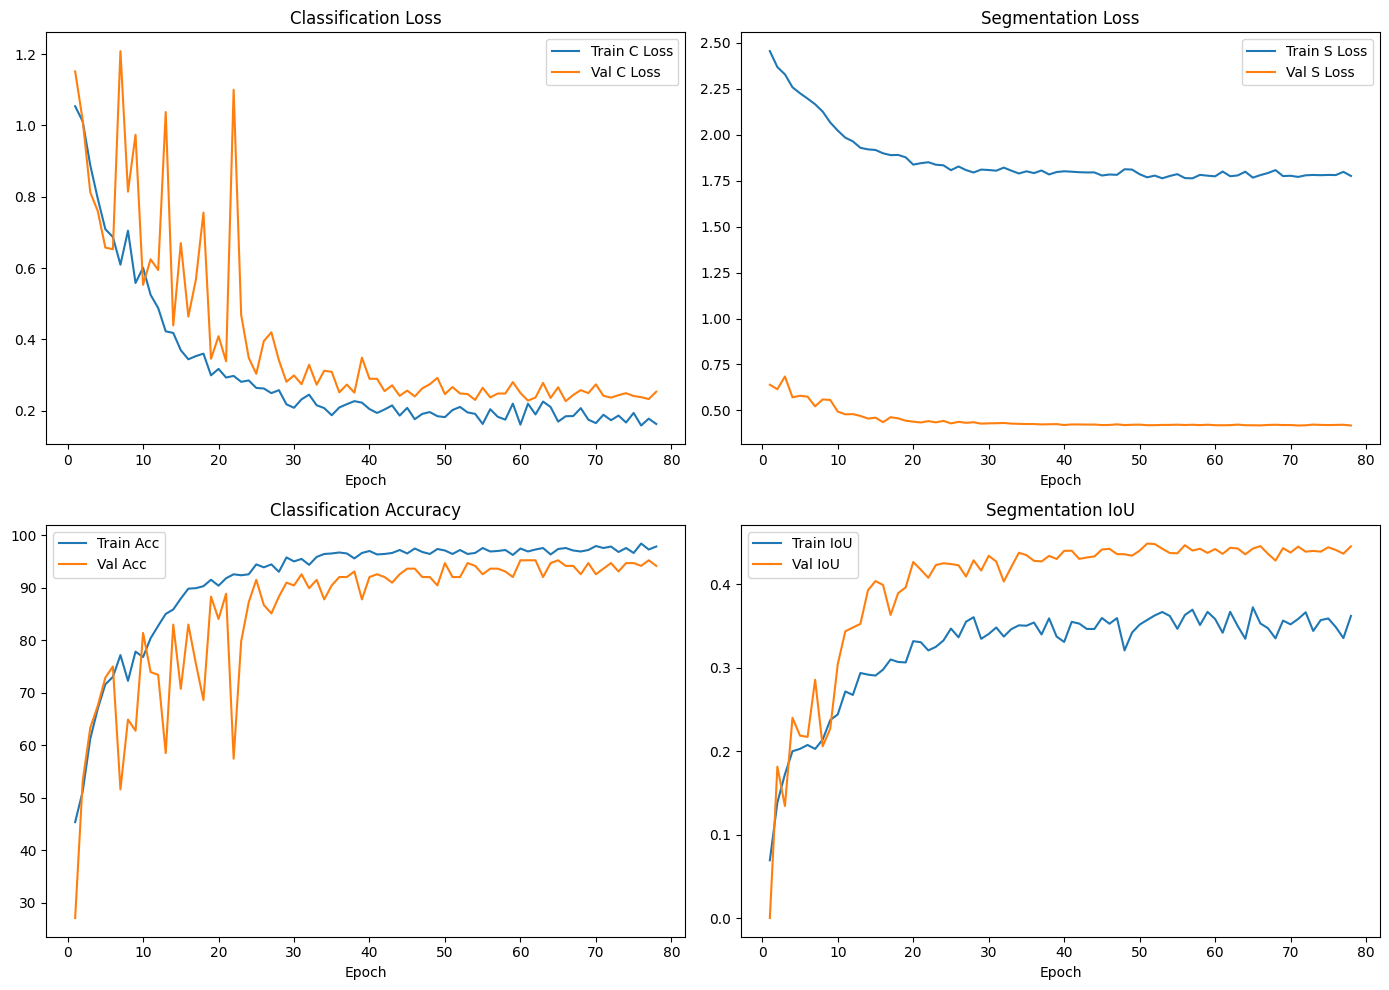

In [34]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = self.fc1(y)
        y = F.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.attention = SEBlock(out_channels)

    def forward(self, x):
        x = self.double_conv(x)
        x = self.attention(x)
        return x

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        self.attention = SEBlock(out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.attention(x)
        return x

class UNetMultiTask(nn.Module):
    def __init__(self, n_classes=3):
        super(UNetMultiTask, self).__init__()
        self.in_channels = 1
        self.seg_channels = 1
        self.class_classes = n_classes

        self.inc = DoubleConv(1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        self.up1 = Up(512 + 256, 256)
        self.up2 = Up(256 + 128, 128)
        self.up3 = Up(128 + 64, 64)

        self.out_seg = nn.Conv2d(64, self.seg_channels, kernel_size=1)

        self.ds_out1 = nn.Conv2d(256, self.seg_channels, kernel_size=1)
        self.ds_out2 = nn.Conv2d(128, self.seg_channels, kernel_size=1)

        self.classifier = nn.Sequential(
            nn.Linear(512 + 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, self.class_classes)
        )

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        x = self.up1(x4, x3)
        x_ds1 = self.ds_out1(x)

        x = self.up2(x, x2)
        x_ds2 = self.ds_out2(x)

        x = self.up3(x, x1)

        seg_out = self.out_seg(x)
        seg_out_sigmoid = torch.sigmoid(seg_out)

        seg_mean = torch.mean(seg_out_sigmoid, dim=(2, 3))
        seg_std = torch.std(seg_out_sigmoid, dim=(2, 3))
        seg_max = torch.amax(seg_out_sigmoid, dim=(2, 3))
        seg_features = torch.cat([seg_mean, seg_std, seg_max], dim=1)

        pooled_x4 = F.adaptive_avg_pool2d(x4, 1).flatten(1)
        encoder_features = pooled_x4
        class_features = torch.cat([encoder_features, seg_features], dim=1)
        class_out = self.classifier(class_features)

        return seg_out, class_out, x_ds1, x_ds2

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1).float()

    intersection = (pred * target).sum(dim=1)
    union = pred.sum(dim=1) + target.sum(dim=1)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetMultiTask().to(device)

classification_criterion = nn.CrossEntropyLoss()
segmentation_criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

def early_stopping_check(val_acc, best_val_acc, patience, counter):
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
    else:
        counter += 1
    if counter >= patience:
        return True, best_val_acc, counter
    return False, best_val_acc, counter

patience = 18
counter = 0
best_val_acc = 0.0
best_model_weights = None
epochs = 150

train_cls_losses, train_seg_losses, train_accs,   train_ious = [], [], [], []
val_cls_losses,   val_seg_losses,   val_accs,     val_ious   = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_cls_loss = 0.0
    running_seg_loss = 0.0
    running_iou_sum  = 0.0
    correct = total = 0

    for images, masks, labels in tqdm(train_loader, desc=f"Train E{epoch+1}", ncols=100):
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)
        optimizer.zero_grad()

        seg_out, class_out, x_ds1, x_ds2 = model(images)

        cls_loss = classification_criterion(class_out, labels)
        bce_loss = segmentation_criterion(seg_out, masks.float())
        dice = dice_loss(seg_out, masks)
        main_seg_loss = bce_loss + dice

        x_ds1_up = F.interpolate(x_ds1, size=masks.shape[-2:], mode='bilinear', align_corners=True)
        x_ds2_up = F.interpolate(x_ds2, size=masks.shape[-2:], mode='bilinear', align_corners=True)

        ds1_bce_loss = segmentation_criterion(x_ds1_up, masks.float())
        ds1_dice_loss = dice_loss(x_ds1_up, masks)
        ds1_loss = ds1_bce_loss + ds1_dice_loss

        ds2_bce_loss = segmentation_criterion(x_ds2_up, masks.float())
        ds2_dice_loss = dice_loss(x_ds2_up, masks)
        ds2_loss = ds2_bce_loss + ds2_dice_loss

        seg_loss = main_seg_loss + 0.3 * (ds1_loss + ds2_loss)
        loss = cls_loss + seg_loss

        loss.backward()
        optimizer.step()

        running_cls_loss += cls_loss.item()
        running_seg_loss += seg_loss.item()

        preds = class_out.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

        with torch.no_grad():
            probs     = torch.sigmoid(seg_out) > 0.5
            truths    = masks.bool()
            inter     = (probs & truths).sum(dim=(1,2,3)).float()
            union     = (probs | truths).sum(dim=(1,2,3)).float().clamp(min=1e-6)
            sample_iou = (inter / union).sum().item()
            running_iou_sum += sample_iou


    train_cls_losses.append(running_cls_loss / len(train_loader))
    train_seg_losses.append(running_seg_loss / len(train_loader))
    train_accs.append(100 * correct / total)
    train_ious.append(running_iou_sum / total)


    model.eval()
    val_running_cls = 0.0
    val_running_seg = 0.0
    val_iou_sum     = 0.0
    val_correct = val_total = 0

    with torch.no_grad():
        for images, masks, labels in val_loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            seg_out, class_out, x_ds1, x_ds2 = model(images)

            cls_loss = classification_criterion(class_out, labels)
            seg_loss = segmentation_criterion(seg_out, masks.float().unsqueeze(1).squeeze(2))

            val_running_cls += cls_loss.item()
            val_running_seg += seg_loss.item()

            preds = class_out.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total   += labels.size(0)

            probs     = torch.sigmoid(seg_out) > 0.5
            truths    = masks.bool()
            inter     = (probs & truths).sum(dim=(1,2,3)).float()
            union     = (probs | truths).sum(dim=(1,2,3)).float().clamp(min=1e-6)
            val_iou_sum += (inter / union).sum().item()

    val_cls_losses.append(val_running_cls / len(val_loader))
    val_seg_losses.append(val_running_seg / len(val_loader))
    val_accs.append(100 * val_correct / val_total)
    val_ious.append(val_iou_sum / val_total)

    print(f"Epoch {epoch+1}: "
          f"Train [C L {train_cls_losses[-1]:.4f} | S L {train_seg_losses[-1]:.4f} | Acc {train_accs[-1]:.1f}% | IoU {train_ious[-1]:.3f}]   "
          f"Val   [C L {val_cls_losses[-1]:.4f} | S L {val_seg_losses[-1]:.4f} | Acc {val_accs[-1]:.1f}% | IoU {val_ious[-1]:.3f}]")

    stop, best_val_acc, counter = early_stopping_check(val_accs[-1], best_val_acc, patience, counter)
    if stop:
        print(f"Early stop at epoch {epoch+1}, best val acc {best_val_acc:.2f}%")
        break
    scheduler.step(val_running_cls)
    if val_accs[-1] > best_val_acc:
        best_model_weights = model.state_dict()


if best_model_weights:
    model.load_state_dict(best_model_weights)

epochs_range = range(1, len(train_cls_losses) + 1)
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(epochs_range, train_cls_losses, label='Train C Loss')
plt.plot(epochs_range, val_cls_losses,   label='Val C Loss')
plt.title('Classification Loss');  plt.xlabel('Epoch'); plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs_range, train_seg_losses, label='Train S Loss')
plt.plot(epochs_range, val_seg_losses,   label='Val S Loss')
plt.title('Segmentation Loss');  plt.xlabel('Epoch'); plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, val_accs,   label='Val Acc')
plt.title('Classification Accuracy');  plt.xlabel('Epoch'); plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs_range, train_ious, label='Train IoU')
plt.plot(epochs_range, val_ious,   label='Val IoU')
plt.title('Segmentation IoU');  plt.xlabel('Epoch'); plt.legend()

plt.tight_layout()
plt.show()

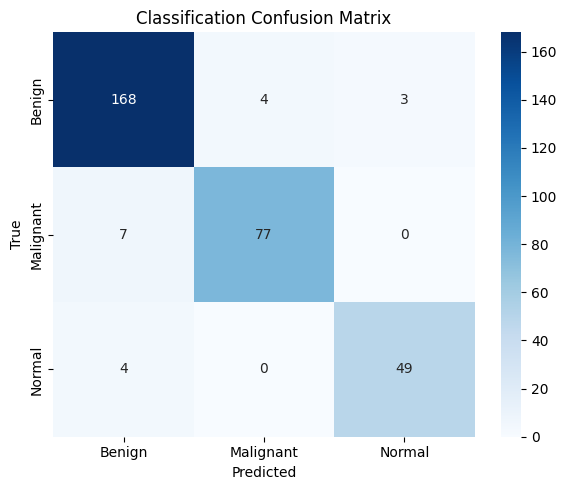


--- Classification Metrics ---

              precision    recall  f1-score   support

      Benign       0.94      0.96      0.95       175
   Malignant       0.95      0.92      0.93        84
      Normal       0.94      0.92      0.93        53

    accuracy                           0.94       312
   macro avg       0.94      0.93      0.94       312
weighted avg       0.94      0.94      0.94       312


--- Segmentation Metrics (Pixel-wise) ---

Precision: 0.7514
Recall:    0.6497
F1 Score:  0.6969
IoU Score: 0.5348


In [16]:


all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, _, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        _, class_out, _, _ = model(images)
        _, predicted = torch.max(class_out, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

labels_names = ["Benign", "Malignant", "Normal"]

cm = confusion_matrix(all_targets, all_preds)
df_cm = pd.DataFrame(cm, index=labels_names, columns=labels_names)

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Classification Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n--- Classification Metrics ---\n")
print(classification_report(all_targets, all_preds, target_names=labels_names))


from sklearn.metrics import precision_score, recall_score, f1_score

all_seg_preds = []
all_seg_targets = []

model.eval()
with torch.no_grad():
    for images, masks, _ in test_loader:
        images, masks = images.to(device), masks.to(device)
        seg_out, _, _, _ = model(images)

        seg_preds = torch.sigmoid(seg_out) > 0.6
        seg_preds = seg_preds.cpu().numpy().astype(np.uint8)
        masks = masks.unsqueeze(1).cpu().numpy().astype(np.uint8)

        all_seg_preds.extend(seg_preds.reshape(seg_preds.shape[0], -1))
        all_seg_targets.extend(masks.reshape(masks.shape[0], -1))

all_seg_preds = np.concatenate(all_seg_preds)
all_seg_targets = np.concatenate(all_seg_targets)

precision = precision_score(all_seg_targets.flatten(), all_seg_preds.flatten(), zero_division=0)
recall = recall_score(all_seg_targets.flatten(), all_seg_preds.flatten(), zero_division=0)
f1 = f1_score(all_seg_targets.flatten(), all_seg_preds.flatten(), zero_division=0)

intersection = np.logical_and(all_seg_targets, all_seg_preds).sum()
union        = np.logical_or(all_seg_targets, all_seg_preds).sum()
iou_score    = intersection / union if union > 0 else 0.0

print("\n--- Segmentation Metrics (Pixel-wise) ---\n")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"IoU Score: {iou_score:.4f}")

In [25]:


predicted_masks = []
predicted_labels = []
print("Running inference on test set...")

model.eval()
with torch.no_grad():
    for images, _, _ in tqdm(test_loader, desc="Predicting", ncols=100):
        images = images.to(device)

        seg_out, class_out, _, _ = model(images)
        predicted_masks.extend(seg_out.cpu())
        _, class_preds = torch.max(class_out, dim=1)
        predicted_labels.extend(class_preds.cpu())

def plot_side_by_side(dataset, predicted_masks, predicted_labels, num_images=30):
    num_images = min(num_images, len(dataset))
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    plt.figure(figsize=(15, 5 * num_images))

    for i, idx in enumerate(random_indices):
        image, gt_mask, true_label = dataset[idx]

        pred_mask = predicted_masks[idx]
        pred_label = predicted_labels[idx]

        original_image = image.permute(1, 2, 0).cpu().numpy()
        gt_mask = gt_mask.permute(1, 2, 0).cpu().numpy()

        pred_mask = torch.sigmoid(pred_mask).squeeze().numpy()
        pred_mask = (pred_mask > 0.6).astype(np.uint8)

        if original_image.shape[-1] == 1:
            original_image = original_image.squeeze(-1)
        if gt_mask.shape[-1] == 1:
            gt_mask = gt_mask.squeeze(-1)

        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(original_image, cmap='gray')
        plt.title(f"Original Image\nTrue Label: {labeler(true_label)}")
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(gt_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title(f"Predicted Mask\nPred Label: {labeler(pred_label.item())}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_side_by_side(test_dataset, predicted_masks, predicted_labels, num_images=30)

Output hidden; open in https://colab.research.google.com to view.